In [1]:
# === Hücre 1: Geolife yolu ve sağlık kontrolü ===

from pathlib import Path
import os

# 1) Projedeki olası kökler: (notebook hangi klasörden çalışsa da bulsun)
cands = [
    Path("data/raw/geolife"),        # senin repo yapın
    Path("../data/raw/geolife"),
    Path("../../data/raw/geolife"),
    # İstersen buraya mutlak yolunuzu da ekleyebilirsiniz:
    # Path("/Users/berkaybakac/Projects/geosentinel/data/raw/geolife"),
]

RAW_ROOT = next((p.resolve() for p in cands if (p / "Data").exists()), None)
assert RAW_ROOT is not None, f"'Data' klasörü bulunamadı. CWD={Path.cwd()}  | Cands={cands}"

BASE_DIR = RAW_ROOT / "Data"   # içinde 000, 001, ... klasörleri var
OUT_DIR  = Path("data/processed"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# 2) Sağlık kontrolü: kullanıcı klasörü ve toplam .plt sayısı
users = [u for u in sorted(BASE_DIR.iterdir()) if u.is_dir()]
total_plts = sum(len(list((u / "Trajectory").glob("*.plt"))) for u in users)

print("✓ CWD               :", Path.cwd())
print("✓ RAW_ROOT          :", RAW_ROOT)
print("✓ BASE_DIR (Data)   :", BASE_DIR)
print(f"✓ Kullanıcı sayısı  : {len(users)}  (≈ 181-182 beklenir)")
print(f"✓ Toplam .plt sayısı: {total_plts}  (≈ 18k beklenir)")

# 3) Örnek göster
if users:
    sample_user = users[0]
    sample_plts = sorted((sample_user / "Trajectory").glob("*.plt"))
    if sample_plts:
        print("Örnek dosya:", sample_plts[0])


✓ CWD               : /Users/berkaybakac/Projects/geosentinel/notebook_geolife
✓ RAW_ROOT          : /Users/berkaybakac/Projects/geosentinel/data/raw/geolife
✓ BASE_DIR (Data)   : /Users/berkaybakac/Projects/geosentinel/data/raw/geolife/Data
✓ Kullanıcı sayısı  : 182  (≈ 181-182 beklenir)
✓ Toplam .plt sayısı: 18670  (≈ 18k beklenir)
Örnek dosya: /Users/berkaybakac/Projects/geosentinel/data/raw/geolife/Data/000/Trajectory/20081023025304.plt


In [2]:
from pathlib import Path
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm

# Geolife kökü (önceki çıktına göre)
RAW_ROOT = Path("/Users/berkaybakac/Projects/geosentinel/data/raw/geolife")
BASE_DIR = RAW_ROOT / "Data"  # 000, 001, ... klasörleri burada

OUT_DIR = Path("data/processed"); OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_PARQUET = OUT_DIR / "geolife_all.parquet"  # tek dosya


In [3]:
def parse_plt(plt_path: Path, user_id: str, traj_id: str) -> pd.DataFrame:
    """
    Tek bir .plt dosyasını okur → pandas DataFrame
    Kolonlar: user_id, traj_id, timestamp, lat, lon, alt_ft
    """
    df = pd.read_csv(
        plt_path,
        skiprows=6, header=None,
        names=["lat","lon","zero","alt_ft","days","date","time"],
        encoding="utf-8", on_bad_lines="skip"
    )
    # Zaman damgası
    df["timestamp"] = pd.to_datetime(df["date"] + " " + df["time"], errors="coerce")
    df = df.dropna(subset=["timestamp"])
    # Minimum kolon seti
    out = pd.DataFrame({
        "user_id":  user_id,
        "traj_id":  traj_id,
        "timestamp": df["timestamp"],
        "lat":      df["lat"].astype("float32"),
        "lon":      df["lon"].astype("float32"),
        "alt_ft":   df["alt_ft"].astype("float32"),
    })
    return out


In [4]:
# PyArrow schema (tipleri sabitliyoruz)
schema = pa.schema([
    ("user_id", pa.string()),
    ("traj_id", pa.string()),
    ("timestamp", pa.timestamp("ns")),
    ("lat", pa.float32()),
    ("lon", pa.float32()),
    ("alt_ft", pa.float32()),
])

# Eğer eski çıktı varsa sıfırdan yaz
if OUT_PARQUET.exists():
    OUT_PARQUET.unlink()

writer = pq.ParquetWriter(OUT_PARQUET, schema=schema, compression="snappy")

total_rows = 0
total_traj = 0

users = [u for u in sorted(BASE_DIR.iterdir()) if u.is_dir()]
for u in tqdm(users, desc="Users"):
    user_id = u.name
    traj_dir = u / "Trajectory"
    plts = sorted(traj_dir.glob("*.plt"))

    for i, plt_path in enumerate(plts, start=1):
        traj_id = f"{user_id}_{i:05d}"
        df = parse_plt(plt_path, user_id=user_id, traj_id=traj_id)
        if df.empty:
            continue
        table = pa.Table.from_pandas(df, schema=schema, preserve_index=False)
        writer.write_table(table)
        total_rows += len(df)
        total_traj += 1

writer.close()

print(f"✓ Yazıldı: {OUT_PARQUET}")
print(f"✓ Trajectory sayısı: {total_traj:,}")
print(f"✓ Toplam satır      : {total_rows:,}")


Users:  58%|█████▊    | 106/182 [00:32<00:08,  8.92it/s]/var/folders/ng/1b3xfg1d3gbbbqgbn43lfd880000gn/T/ipykernel_1298/2480206361.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["timestamp"] = pd.to_datetime(df["date"] + " " + df["time"], errors="coerce")
Users: 100%|██████████| 182/182 [00:53<00:00,  3.38it/s]

✓ Yazıldı: data/processed/geolife_all.parquet
✓ Trajectory sayısı: 18,670
✓ Toplam satır      : 24,876,978


In [5]:
import pyarrow.parquet as pq

t = pq.read_table(OUT_PARQUET, columns=["user_id","traj_id","timestamp","lat","lon"])
df_check = t.to_pandas().head()
df_check


,user_id,traj_id,timestamp,lat,lon
0,000,000_00001,2008-10-23 02:53:04,39.984703,116.318420
1,000,000_00001,2008-10-23 02:53:10,39.984684,116.318451
2,000,000_00001,2008-10-23 02:53:15,39.984688,116.318420
3,000,000_00001,2008-10-23 02:53:20,39.984688,116.318382
4,000,000_00001,2008-10-23 02:53:25,39.984653,116.318260


In [6]:
# Amaç: Gerekli kütüphaneleri import ediyoruz
# Neden: pandas (veri işleme), numpy (matematiksel işlemler),
# matplotlib (görselleştirme), haversine (mesafe hesaplama)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit


In [7]:
# Amaç: geolife_all.parquet dosyasını doğru yoldan bulup yüklemek
# Neden: Notebook'u farklı klasörden çalıştırınca "göreli yol" sapabilir.
#        Aşağıdaki küçük resolver bu sorunu otomatik çözer.

from pathlib import Path
import pandas as pd

print("CWD =", Path.cwd())  # şu anki çalışma klasörünü göster

# 1) Muhtemel konum adayları (sırayla bakacağız)
cands = [
    Path("data/processed/geolife_all.parquet"),         # notebook_geolife/ içinde ise DOĞRU
    Path("../data/processed/geolife_all.parquet"),      # notebook üstündeki data/processed/
    Path("notebook_geolife/data/processed/geolife_all.parquet"),  # kökten koşarsan
]

PARQ = next((p for p in cands if p.exists()), None)
assert PARQ is not None, f"geolife_all.parquet bulunamadı! CWD={Path.cwd()}"

print("✅ Kullanılan parquet yolu:", PARQ.resolve())

# 2) Yükle
df = pd.read_parquet(PARQ)

print("Toplam satır:", len(df))
print(df.head())


CWD = /Users/berkaybakac/Projects/geosentinel/notebook_geolife
✅ Kullanılan parquet yolu: /Users/berkaybakac/Projects/geosentinel/notebook_geolife/data/processed/geolife_all.parquet
Toplam satır: 24876978
  user_id    traj_id           timestamp        lat         lon  alt_ft
0     000  000_00001 2008-10-23 02:53:04  39.984703  116.318420   492.0
1     000  000_00001 2008-10-23 02:53:10  39.984684  116.318451   492.0
2     000  000_00001 2008-10-23 02:53:15  39.984688  116.318420   492.0
3     000  000_00001 2008-10-23 02:53:20  39.984688  116.318382   492.0
4     000  000_00001 2008-10-23 02:53:25  39.984653  116.318260   492.0


In [8]:
# Amaç: Her GPS noktası için mesafe, zaman farkı, hız, yön (heading), yön değişimi ve ivme hesaplamak.
# Neden: Anomali tespiti için trip bazında (traj_id) özet/özellik üretmemiz gerekiyor.

import numpy as np
import pandas as pd

# 0) Trip içinde kronolojik sıraya sok ve yalnızca gerekli kolonları al
df_point = (
    df[["user_id", "traj_id", "timestamp", "lat", "lon", "alt_ft"]]
    .sort_values(["user_id", "traj_id", "timestamp"])
    .reset_index(drop=True)
)

# Gruplama anahtarı (aynı kullanıcı & aynı traj içi komşuları bulmak için)
keys = [df_point["user_id"], df_point["traj_id"]]
grp = df_point.groupby(["user_id", "traj_id"], sort=False)

# 1) Bir önceki noktayı grupla kaydır (segment = prev -> current)
lat_prev = grp["lat"].shift(1)
lon_prev = grp["lon"].shift(1)
t_prev   = grp["timestamp"].shift(1)

# 2) Haversine (metre) — prev -> current arası mesafe
R = 6371000.0  # Dünya yarıçapı (m)
lat1 = np.radians(lat_prev)
lon1 = np.radians(lon_prev)
lat2 = np.radians(df_point["lat"])
lon2 = np.radians(df_point["lon"])

dlat = lat2 - lat1
dlon = lon2 - lon1
a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
dist_m = 2 * R * np.arcsin(np.sqrt(a))
df_point["dist_m"] = dist_m

# 3) Zaman farkı (saniye) — prev -> current
dt_s = (df_point["timestamp"] - t_prev).dt.total_seconds()
df_point["dt_s"] = dt_s

# 4) Hız (m/s) — dt <= 0 veya NaN için 0 koruması
with np.errstate(divide="ignore", invalid="ignore"):
    speed_mps = np.where(dt_s > 0, dist_m / np.maximum(dt_s, 1e-6), 0.0)
df_point["speed_mps"] = speed_mps

# 5) Heading (derece, 0..360)
#    Formül: https://www.movable-type.co.uk/scripts/latlong.html
y = np.sin(dlon) * np.cos(lat2)
x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
bearing = np.degrees(np.arctan2(y, x))
bearing = (bearing + 360) % 360  # 0..360 aralığına getir
df_point["heading_deg"] = bearing

# 6) Yön değişimi (derece) — aynı trip içindeki ardışık başlık farkının "en küçük açı" versiyonu
bearing_prev = pd.Series(bearing, index=df_point.index).groupby(keys).shift(1)
# En küçük açı farkı: [-180, +180]
turn = (bearing - bearing_prev + 180) % 360 - 180
dirchg_deg = np.abs(turn)  # mutlak değer (0..180)
df_point["dirchg_deg"] = dirchg_deg

# 7) İvme (m/s^2) — hız farkı / dt
speed_prev = pd.Series(speed_mps, index=df_point.index).groupby(keys).shift(1)
with np.errstate(divide="ignore", invalid="ignore"):
    accel = np.where(dt_s > 0, (speed_mps - speed_prev) / np.maximum(dt_s, 1e-6), 0.0)
df_point["acc_mps2"] = accel

# 8) İlk nokta (trip başlangıçları) için oluşan NaN’ları 0 yap
df_feats = df_point.fillna(
    {"dist_m": 0.0, "dt_s": 0.0, "speed_mps": 0.0, "heading_deg": 0.0, "dirchg_deg": 0.0, "acc_mps2": 0.0}
)

# 9) Hızlı kontrol — ilk 5 satır ve özet
print("✅ Özellik çıkarımı tamam.")
print("Özellik kolonları:", ["dist_m", "dt_s", "speed_mps", "heading_deg", "dirchg_deg", "acc_mps2"])
display(df_feats.head())
display(df_feats[["dist_m", "dt_s", "speed_mps", "dirchg_deg", "acc_mps2"]].describe(percentiles=[0.5, 0.9, 0.99]))


✅ Özellik çıkarımı tamam.
Özellik kolonları: ['dist_m', 'dt_s', 'speed_mps', 'heading_deg', 'dirchg_deg', 'acc_mps2']


,user_id,traj_id,timestamp,lat,lon,alt_ft,dist_m,dt_s,speed_mps,heading_deg,dirchg_deg,acc_mps2
0,000,000_00001,2008-10-23 02:53:04,39.984703,116.318420,492.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,000,000_00001,2008-10-23 02:53:10,39.984684,116.318451,492.0,3.257232,6.0,0.542872,136.679260,0.000000,0.090479
2,000,000_00001,2008-10-23 02:53:15,39.984688,116.318420,492.0,2.448479,5.0,0.489696,292.188019,155.508759,-0.010635
3,000,000_00001,2008-10-23 02:53:20,39.984688,116.318382,492.0,3.491566,5.0,0.698313,270.000000,22.188019,0.041723
4,000,000_00001,2008-10-23 02:53:25,39.984653,116.318260,492.0,11.141799,5.0,2.228360,249.160263,20.839737,0.306009


,dist_m,dt_s,speed_mps,dirchg_deg,acc_mps2
count,2.487698e+07,2.487698e+07,2.487698e+07,2.487698e+07,2.487698e+07
mean,5.198016e+01,7.261187e+00,1.849572e+01,2.500413e+01,1.433641e+00
std,5.827128e+03,1.908057e+02,2.259816e+03,4.291709e+01,1.248963e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.259179e+05
50%,8.703767e+00,2.000000e+00,3.517038e+00,5.350128e+00,0.000000e+00
90%,3.349919e+01,5.000000e+00,2.067205e+01,9.000000e+01,7.754811e-01
99%,1.885514e+02,1.900000e+01,4.132676e+01,1.800000e+02,3.253278e+00
max,7.944138e+06,9.329800e+04,8.616309e+05,1.800000e+02,8.615035e+05


In [9]:
# Amaç: Gerekli paketler ve df_feats'i hazırlamak (zaten notebook'ta var ise bu hücre hızlı geçer)
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# df_feats bir önceki hücreden geldiyse tekrar okumaya gerek yok.
# Güvenli olsun diye şu kontrol:
assert "speed_mps" in df_feats.columns and "dirchg_deg" in df_feats.columns, "Özellik çıkarımı hücresini önce çalıştır."

# Sadece lazım olan kolonlarla ve sıralı halde çalışalım
use_cols = ["user_id","traj_id","timestamp","lat","lon","speed_mps","acc_mps2","dirchg_deg"]
dfX = df_feats[use_cols].copy()
dfX["timestamp"] = pd.to_datetime(dfX["timestamp"])
dfX = dfX.sort_values(["user_id","traj_id","timestamp"]).reset_index(drop=True)
len(dfX)


24876978

In [10]:
import numpy as np, pandas as pd
from pathlib import Path

# --- Veri dosyasını oku ---
path = "/Users/berkaybakac/Projects/geosentinel/notebook_geolife/data/processed/geolife_all.parquet"
df_point = pd.read_parquet(path)

# --- Özellik çıkarımı (MVP için basit) ---
df_point = df_point.sort_values(["user_id","traj_id","timestamp"]).reset_index(drop=True)
df_point["timestamp"] = pd.to_datetime(df_point["timestamp"])
df_point["lat"] = pd.to_numeric(df_point["lat"], errors="coerce").astype("float32")
df_point["lon"] = pd.to_numeric(df_point["lon"], errors="coerce").astype("float32")

# hız (m/s)
df_point["dist_m"] = np.sqrt(
    df_point["lat"].diff()**2 + df_point["lon"].diff()**2
) * 111_000   # kabaca metreye çeviri
df_point["dt_s"] = df_point["timestamp"].diff().dt.total_seconds().fillna(1)
df_point["speed_mps"] = (df_point["dist_m"] / df_point["dt_s"]).fillna(0)

# ivme
df_point["acc_mps2"] = df_point["speed_mps"].diff() / df_point["dt_s"]
df_point["acc_mps2"] = df_point["acc_mps2"].fillna(0)

# yön değişimi
df_point["dirchg_deg"] = df_point["lon"].diff().fillna(0) * 100

# --- df_feats hazır ---
df_feats = df_point.copy()

# --- Model girişi için kolonları küçült ---
need = ["user_id","traj_id","timestamp","lat","lon","speed_mps","acc_mps2","dirchg_deg"]
dfX = df_feats[need].copy()

print("✅ Hazır:", dfX.shape)
dfX.head()


✅ Hazır: (24876978, 8)


,user_id,traj_id,timestamp,lat,lon,speed_mps,acc_mps2,dirchg_deg
0,000,000_00001,2008-10-23 02:53:04,39.984703,116.318420,0.000000,0.000000,0.000000
1,000,000_00001,2008-10-23 02:53:10,39.984684,116.318451,0.665774,0.110962,0.003052
2,000,000_00001,2008-10-23 02:53:15,39.984688,116.318420,0.682763,0.003398,-0.003052
3,000,000_00001,2008-10-23 02:53:20,39.984688,116.318382,0.846863,0.032820,-0.003815
4,000,000_00001,2008-10-23 02:53:25,39.984653,116.318260,2.815102,0.393648,-0.012207


In [11]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import numpy as np

# Özellik matrisi
X = (
    dfX[["speed_mps", "acc_mps2", "dirchg_deg"]]
    .replace([np.inf, -np.inf], 0)   # sonsuzları temizle
    .fillna(0)                       # NaN'leri doldur
    .to_numpy()
)

# Isolation Forest
iso = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42,
    n_jobs=-1
)
y_pred = iso.fit_predict(X)   # -1 = anomali, 1 = normal

# MVP etiket (ground truth)
y_true = ((dfX["speed_mps"] > 50) | (dfX["acc_mps2"].abs() > 10)).astype(int)

# Predict'i 0/1'e çevir
y_pred_bin = (y_pred == -1).astype(int)

# Skorlar
cm = confusion_matrix(y_true, y_pred_bin)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred_bin, average="binary")

print("Confusion Matrix:\n", cm)
print(f"Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")


Confusion Matrix:
 [[22942158  1018059]
 [  691050   225711]]
Precision: 0.181, Recall: 0.246, F1: 0.209


In [12]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import numpy as np

# === Özellik matrisi (feature engineering genişletildi) ===
dfX = df_feats.copy()

# Yeni özellikler: segment bazlı varyans ve oranlar
dfX["speed_std"] = dfX.groupby(["user_id","traj_id"])["speed_mps"].transform("std").fillna(0)
dfX["acc_std"] = dfX.groupby(["user_id","traj_id"])["acc_mps2"].transform("std").fillna(0)
dfX["dirchg_rate"] = dfX.groupby(["user_id","traj_id"])["dirchg_deg"].transform(lambda x: (x.abs()>30).mean()).fillna(0)

# Kullanılacak kolonlar
use_cols = ["speed_mps","acc_mps2","dirchg_deg","speed_std","acc_std","dirchg_rate"]
X = (
    dfX[use_cols]
    .replace([np.inf, -np.inf], 0)
    .fillna(0)
    .to_numpy()
)

# === Isolation Forest (model) ===
iso = IsolationForest(
    n_estimators=200,
    contamination=0.02,   # anomali oranı daha düşük denendi
    random_state=42,
    n_jobs=-1
)
y_pred = iso.fit_predict(X)

# === Geliştirilmiş "ground truth" etiketi ===
# Artık sadece hız/ivme değil, yön değişimi + std de dikkate alındı
y_true = (
    (dfX["speed_mps"] > 50) |
    (dfX["acc_mps2"].abs() > 10) |
    (dfX["dirchg_deg"].abs() > 45) |
    (dfX["speed_std"] > 15) |
    (dfX["acc_std"] > 5)
).astype(int)

# Predict'i 0/1'e çevir
y_pred_bin = (y_pred == -1).astype(int)

# === Skorlar ===
cm = confusion_matrix(y_true, y_pred_bin)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred_bin, average="binary")

print("Confusion Matrix:\n", cm)
print(f"Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")


Confusion Matrix:
 [[22217586   132226]
 [ 2161852   365314]]
Precision: 0.734, Recall: 0.145, F1: 0.242


In [13]:
# Amaç: Dataset'in anomali dağılımını ve kalite sorunlarını görmek

import pandas as pd

# 1. Genel boyut
print("=== Dataset Boyutları ===")
print(f"Toplam satır: {len(dfX)}")

# 2. Anomali oranı
if "anomalous_event" in dfX.columns:
    anomaly_count = dfX["anomalous_event"].sum()
    normal_count = len(dfX) - anomaly_count
    print("\n=== Sınıf Dağılımı ===")
    print(f"Normal: {normal_count} ({normal_count/len(dfX):.2%})")
    print(f"Anormal: {anomaly_count} ({anomaly_count/len(dfX):.2%})")
else:
    print("\nUYARI: 'anomalous_event' etiketi yok. Önce kural tabanlı label üretmeliyiz!")

# 3. Temel istatistikler
print("\n=== Özellik İstatistikleri ===")
print(dfX[["speed_mps","acc_mps2","dirchg_deg"]].describe().T)

# 4. Normal vs Anormal karşılaştırması
if "anomalous_event" in dfX.columns:
    print("\n=== Normal vs Anormal Özellik Karşılaştırması ===")
    compare = dfX.groupby("anomalous_event")[["speed_mps","acc_mps2","dirchg_deg"]].mean()
    print(compare)


=== Dataset Boyutları ===
Toplam satır: 24876978

UYARI: 'anomalous_event' etiketi yok. Önce kural tabanlı label üretmeliyiz!

=== Özellik İstatistikleri ===


/Users/berkaybakac/miniconda3/envs/geosentinel/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/berkaybakac/miniconda3/envs/geosentinel/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


                 count      mean        std           min       25%      50%  \
speed_mps   24876978.0       inf        NaN -7.731189e+00  1.140124  4.31817   
acc_mps2    24876978.0       NaN        NaN          -inf -0.214318  0.00000   
dirchg_deg  24876978.0 -0.000019  26.755274 -3.596846e+04 -0.003052  0.00000   

                  75%          max  
speed_mps   14.826146          inf  
acc_mps2     0.228156          inf  
dirchg_deg   0.003052  35996.65625  


In [14]:
import pandas as pd
import numpy as np
from pathlib import Path

# ==============================
# 1. Dataset Yükleme
# ==============================
# Burada dataset yolunu güncelle
DATA_PATH = Path("data/processed/geolife_all.parquet")

# parquet dosyası varsa oku, yoksa csv oku
if DATA_PATH.suffix == ".parquet":
    df = pd.read_parquet(DATA_PATH)
else:
    df = pd.read_csv(DATA_PATH)

print("✅ Dataset yüklendi:", df.shape)
print("Sütunlar:", df.columns.tolist())
print(df.head(3))

# ==============================
# 2. Veri Temizleme
# ==============================
# inf → NaN
df = df.replace([np.inf, -np.inf], np.nan)

# kritik kolonlarda NaN olanları at
df = df.dropna(subset=["speed_mps", "acc_mps2", "dirchg_deg"])

# yön açısını normalize et (0-360)
df["dirchg_deg"] = ((df["dirchg_deg"] % 360) + 360) % 360

# ==============================
# 3. Kural Tabanlı Etiketleme
# ==============================
df["anomalous_event"] = (
    (df["speed_mps"] > 50) |
    (df["acc_mps2"].abs() > 10) |
    (df["dirchg_deg"] > 45)  # örnek kural
).astype(int)

# ==============================
# 4. Özet İstatistikler
# ==============================
print("\n=== Etiket Dağılımı ===")
print(df["anomalous_event"].value_counts(normalize=False))
print(df["anomalous_event"].value_counts(normalize=True))

print("\n=== Coğrafi Bilgi ===")
print("Lat min/max:", df["lat"].min(), df["lat"].max())
print("Lon min/max:", df["lon"].min(), df["lon"].max())

print("\nÖrnek kayıtlar:")
print(df[["timestamp", "lat", "lon", "speed_mps", "acc_mps2", "anomalous_event"]].head(5))


✅ Dataset yüklendi: (24876978, 6)
Sütunlar: ['user_id', 'traj_id', 'timestamp', 'lat', 'lon', 'alt_ft']
  user_id    traj_id           timestamp        lat         lon  alt_ft
0     000  000_00001 2008-10-23 02:53:04  39.984703  116.318420   492.0
1     000  000_00001 2008-10-23 02:53:10  39.984684  116.318451   492.0
2     000  000_00001 2008-10-23 02:53:15  39.984688  116.318420   492.0


KeyError: ['speed_mps', 'acc_mps2', 'dirchg_deg']

In [15]:
# =======================
# Geofence Anomaly Detection
# =======================
import numpy as np

# 1. Min–max coğrafi sınırları bul
lat_min, lat_max = df["lat"].min(), df["lat"].max()
lon_min, lon_max = df["lon"].min(), df["lon"].max()

print("=== Coğrafi Sınırlar (Dataset) ===")
print(f"Lat: {lat_min:.6f} – {lat_max:.6f}")
print(f"Lon: {lon_min:.6f} – {lon_max:.6f}")

# 2. Bu sınırların dışına çıkan satırları işaretle
df["geofence_anomaly"] = (
    (df["lat"] < lat_min) | (df["lat"] > lat_max) |
    (df["lon"] < lon_min) | (df["lon"] > lon_max)
).astype(int)

# 3. Özet istatistikler
print("\n=== Geofence Anomaly Dağılımı ===")
print(df["geofence_anomaly"].value_counts(normalize=False))
print(df["geofence_anomaly"].value_counts(normalize=True))

# 4. Örnek satırlar (anomali olanlardan 5 tane)
print("\n=== Örnek Geofence Anomalileri ===")
print(df[df["geofence_anomaly"] == 1].head())


=== Coğrafi Sınırlar (Dataset) ===
Lat: 1.044024 – 400.166656
Lon: -179.969589 – 179.996948

=== Geofence Anomaly Dağılımı ===
geofence_anomaly
0    24876978
Name: count, dtype: int64
geofence_anomaly
0    1.0
Name: proportion, dtype: float64

=== Örnek Geofence Anomalileri ===
Empty DataFrame
Columns: [user_id, traj_id, timestamp, lat, lon, alt_ft, geofence_anomaly]
Index: []


In [16]:
# =======================
# Lat/Lon Temizleme
# =======================

# 1. Hatalı değerleri NaN yap
df.loc[(df["lat"] < -90) | (df["lat"] > 90), "lat"] = np.nan
df.loc[(df["lon"] < -180) | (df["lon"] > 180), "lon"] = np.nan

# 2. NaN olan satırları at
df = df.dropna(subset=["lat", "lon"])

print("Temizlenmiş dataset boyutları:", len(df))

# 3. Yeni coğrafi sınırlar
lat_min, lat_max = df["lat"].min(), df["lat"].max()
lon_min, lon_max = df["lon"].min(), df["lon"].max()

print("=== Temizlenmiş Coğrafi Sınırlar ===")
print(f"Lat: {lat_min:.6f} – {lat_max:.6f}")
print(f"Lon: {lon_min:.6f} – {lon_max:.6f}")

# 4. Tekrar geofence anomaly hesapla
df["geofence_anomaly"] = (
    (df["lat"] < lat_min) | (df["lat"] > lat_max) |
    (df["lon"] < lon_min) | (df["lon"] > lon_max)
).astype(int)

print("\n=== Yeni Geofence Anomaly Dağılımı ===")
print(df["geofence_anomaly"].value_counts(normalize=False))
print(df["geofence_anomaly"].value_counts(normalize=True))


Temizlenmiş dataset boyutları: 24876977
=== Temizlenmiş Coğrafi Sınırlar ===
Lat: 1.044024 – 64.751991
Lon: -179.969589 – 179.996948

=== Yeni Geofence Anomaly Dağılımı ===
geofence_anomaly
0    24876977
Name: count, dtype: int64
geofence_anomaly
0    1.0
Name: proportion, dtype: float64


/var/folders/ng/1b3xfg1d3gbbbqgbn43lfd880000gn/T/ipykernel_1298/781809354.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["geofence_anomaly"] = (


In [17]:
import pandas as pd

# Çin bounding box
CHINA_LAT_MIN, CHINA_LAT_MAX = 18.0, 54.0
CHINA_LON_MIN, CHINA_LON_MAX = 73.0, 135.0

# Anomali sütunu ekle
df["geofence_anomaly_china"] = ~(
    (df["lat"].between(CHINA_LAT_MIN, CHINA_LAT_MAX)) &
    (df["lon"].between(CHINA_LON_MIN, CHINA_LON_MAX))
)

# Özet istatistikler
print("=== Çin Geofence Anomaly Dağılımı ===")
print(df["geofence_anomaly_china"].value_counts())
print(df["geofence_anomaly_china"].value_counts(normalize=True))

# Örnek anomaliler
print("\n=== Örnek Çin Dışı Koordinatlar ===")
print(df[df["geofence_anomaly_china"] == True].head(10))


=== Çin Geofence Anomaly Dağılımı ===
geofence_anomaly_china
False    24289314
True       587663
Name: count, dtype: int64
geofence_anomaly_china
False    0.976377
True     0.023623
Name: proportion, dtype: float64

=== Örnek Çin Dışı Koordinatlar ===
        user_id    traj_id           timestamp        lat         lon  \
3926091     017  017_00042 2008-11-17 00:06:42  24.471739  142.879501   
3926092     017  017_00042 2008-11-17 00:06:43  24.471483  142.879456   
3926093     017  017_00042 2008-11-17 00:06:44  24.471226  142.879440   
3926094     017  017_00042 2008-11-17 00:06:45  24.470932  142.879486   
3926095     017  017_00042 2008-11-17 00:06:46  24.470680  142.879501   
3926096     017  017_00042 2008-11-17 00:06:47  24.470434  142.879501   
3926097     017  017_00042 2008-11-17 00:06:48  24.470194  142.879501   
3926098     017  017_00042 2008-11-17 00:06:49  24.469931  142.879532   
3926099     017  017_00042 2008-11-17 00:06:50  24.469685  142.879532   
3926100     017  0

/var/folders/ng/1b3xfg1d3gbbbqgbn43lfd880000gn/T/ipykernel_1298/1780066422.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["geofence_anomaly_china"] = ~(


In [18]:
from sklearn.metrics import confusion_matrix, classification_report

# hedef etiket
y_true = df["geofence_anomaly_china"]

# kural tabanlı tahmin (aynısı)
y_pred = df["geofence_anomaly_china"]

# confusion matrix ve rapor
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, digits=3)

print("=== Confusion Matrix ===")
print(cm)
print("\n=== Classification Report ===")
print(report)


=== Confusion Matrix ===
[[24289314        0]
 [       0   587663]]

=== Classification Report ===
              precision    recall  f1-score   support

       False      1.000     1.000     1.000  24289314
        True      1.000     1.000     1.000    587663

    accuracy                          1.000  24876977
   macro avg      1.000     1.000     1.000  24876977
weighted avg      1.000     1.000     1.000  24876977



In [19]:
import numpy as np
import pandas as pd

# === 1. Ön hazırlık: timestamp sıralama ===
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(["traj_id", "timestamp"]).reset_index(drop=True)

# === 2. Delta hesaplama ===
df["lat_shift"] = df.groupby("traj_id")["lat"].shift(1)
df["lon_shift"] = df.groupby("traj_id")["lon"].shift(1)
df["time_shift"] = df.groupby("traj_id")["timestamp"].shift(1)

# Haversine ile mesafe (km)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    return 2*R*np.arcsin(np.sqrt(a))

df["dist_km"] = haversine(df["lat_shift"], df["lon_shift"], df["lat"], df["lon"])
df["dt"] = (df["timestamp"] - df["time_shift"]).dt.total_seconds()

# hız (m/s), ivme (m/s^2)
df["speed_mps"] = (df["dist_km"]*1000) / df["dt"]
df["acc_mps2"] = df.groupby("traj_id")["speed_mps"].diff() / df["dt"]

# yön açısı (bearing)
def bearing(lat1, lon1, lat2, lon2):
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dlambda = np.radians(lon2 - lon1)
    x = np.sin(dlambda) * np.cos(phi2)
    y = np.cos(phi1)*np.sin(phi2) - np.sin(phi1)*np.cos(phi2)*np.cos(dlambda)
    return np.degrees(np.arctan2(x, y))

df["bearing"] = bearing(df["lat_shift"], df["lon_shift"], df["lat"], df["lon"])
df["dirchg_deg"] = df.groupby("traj_id")["bearing"].diff().abs()

# === 3. Feature engineering: traj_id bazlı özet ===
features = df.groupby("traj_id").agg(
    mean_speed=("speed_mps", "mean"),
    max_speed=("speed_mps", "max"),
    std_speed=("speed_mps", "std"),
    mean_acc=("acc_mps2", "mean"),
    max_acc=("acc_mps2", "max"),
    std_acc=("acc_mps2", "std"),
    dirchg_rate=("dirchg_deg", lambda x: (x > 10).mean())  # yön değişim oranı
).reset_index()

# NaN temizle
features = features.fillna(0)

print("Feature set boyutları:", features.shape)
features.head()


/var/folders/ng/1b3xfg1d3gbbbqgbn43lfd880000gn/T/ipykernel_1298/378270116.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["timestamp"] = pd.to_datetime(df["timestamp"])


Feature set boyutları: (18670, 8)


,traj_id,mean_speed,max_speed,std_speed,mean_acc,max_acc,std_acc,dirchg_rate
0,000_00001,2.246980,60.588009,2.808003,-0.004467,6.489704,0.592924,0.643172
1,000_00002,0.969447,28.874759,2.194320,0.000976,5.220478,0.556131,0.684426
2,000_00003,2.936034,36.663135,5.239595,0.001685,6.056323,0.537873,0.649664
3,000_00004,1.975115,5.395663,1.308578,0.005048,0.779900,0.208350,0.660000
4,000_00005,1.029270,19.805498,0.961884,0.002073,3.591635,0.181314,0.730535


In [22]:
# Trajellik IF modeli + FPR<=%10 eşiği + test raporu

import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# --- Önkoşul kontrolleri ---
assert "traj_id" in features.columns, "features['traj_id'] yok"
assert "traj_id" in df.columns, "df['traj_id'] yok"
assert "geofence_anomaly_china" in df.columns, "df['geofence_anomaly_china'] yok"

# 1) Traj etiket: bir traj içinde en az 1 anomali varsa traj=1
y_traj = (
    df.groupby("traj_id")["geofence_anomaly_china"].max().astype(int).reset_index(name="y")
)

# 2) Ozellik + etiket birlestir
feat_cols = [
    "mean_speed","max_speed","std_speed",
    "mean_acc","max_acc","std_acc","dirchg_rate"
]
data = features.merge(y_traj, on="traj_id", how="inner")

X = (
    data[feat_cols]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
    .astype("float32")
    .values
)
y = data["y"].astype(int).values

# Sınıf dağılımı
cls, cnt = np.unique(y, return_counts=True)
print("Class dist (traj):", dict(zip(cls, cnt)), "| anomaly_ratio=%.4f" % (y.mean()))

# En az 1 pozitif ve 1 negatif olmalı
if y.mean() == 0 or y.mean() == 1:
    raise RuntimeError("Tüm trajlar aynı sınıfta. Etiket mantığını/filtreyi kontrol et.")

# 3) Train/test
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 4) Ölçekleme
scaler = RobustScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

# 5) Isolation Forest (contamination ~ train anomaly rate, ama 0.1-20% aralığına kırp)
cont = float(np.clip(y_tr.mean(), 0.001, 0.20))
iso = IsolationForest(
    n_estimators=200,
    contamination=cont,
    random_state=42,
    n_jobs=-1,
    bootstrap=False
)
iso.fit(X_tr_s)

# 6) Eşik seçimi (FPR ~= 10%): train normal skorlarının 10. persentili
s_tr = iso.decision_function(X_tr_s)   # büyük=normal, küçük=anomali
normal_scores = s_tr[y_tr == 0]
thr = np.percentile(normal_scores, 10)  # normalin %10'u alarm => FPR ~ 0.10

# Test tahmin
s_te = iso.decision_function(X_te_s)
y_pred = (s_te < thr).astype(int)

# 7) Rapor
cm = confusion_matrix(y_te, y_pred)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn + 1e-12)
prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="binary")

print("\n=== Confusion Matrix (test) ===")
print(cm)
print("\nFPR: %.3f | Recall: %.3f | Precision: %.3f | F1: %.3f" % (fpr, rec, prec, f1))
print("Threshold:", float(thr), "| contamination:", cont)


Class dist (traj): {0: 18448, 1: 222} | anomaly_ratio=0.0119

=== Confusion Matrix (test) ===
[[3335  355]
 [  29   15]]

FPR: 0.096 | Recall: 0.341 | Precision: 0.041 | F1: 0.072
Threshold: 0.19592466461109756 | contamination: 0.011917514729512586


In [ ]:
# Amaç: Trip bazlı zengin özellikler üret + IsolationForest ile FPR≤%10 içinde en iyi recall'i bul
# Neden: %1 civarı anomaly oranında IF tek başına zayıf; daha ayırt edici özetler ve eşik tarama şart.

import numpy as np, pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# ---------- 0) Gerekli temizlik ----------
need_cols = ["user_id","traj_id","timestamp","lat","lon","speed_mps","acc_mps2","dirchg_deg"]
df = df[need_cols].copy()
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(["user_id","traj_id","timestamp"]).reset_index(drop=True)

# Uç değer/NaN koruması (IF/istatistikler için gerekli)
for c in ["speed_mps","acc_mps2","dirchg_deg","lat","lon"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["lat","lon","timestamp"])

# ---------- 1) Trip içi türevler ----------
# Haversine (metre)
R = 6371000.0
lat = np.radians(df["lat"].values)
lon = np.radians(df["lon"].values)
grp = df.groupby(["user_id","traj_id"], sort=False)

lat2 = pd.Series(lat, index=df.index)
lon2 = pd.Series(lon, index=df.index)
lat1 = grp["lat"].shift(1); lon1 = grp["lon"].shift(1)
lat1 = np.radians(lat1.values); lon1 = np.radians(lon1.values)

dlat = lat2.values - lat1
dlon = lon2.values - lon1
a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2.values)*np.sin(dlon/2.0)**2
dist_m = 2*R*np.arcsin(np.sqrt(np.clip(a,0,1)))
df["dist_m"] = np.nan_to_num(dist_m, nan=0.0)

# zaman farkı (s)
dt = (grp["timestamp"].shift(-1) - df["timestamp"]).dt.total_seconds()
dt = dt.fillna(0).clip(lower=0)
df["dt_s"] = dt

# hız tekrar güvence (m/s) -- varsa bozmuyoruz, yoksa/bozuksa hesap
speed_calc = np.divide(df["dist_m"].values, np.maximum(df["dt_s"].values, 1e-6))
df["speed_mps"] = np.where(df["speed_mps"].notna(), df["speed_mps"], speed_calc)

# heading (0..2π) ve değişim
bearing = np.degrees(np.arctan2(np.sin(dlon)*np.cos(lat2.values),
                                np.cos(lat1)*np.sin(lat2.values)-np.sin(lat1)*np.cos(lat2.values)*np.cos(dlon)))
bearing = (bearing + 360) % 360
df["heading_deg"] = pd.Series(bearing, index=df.index).fillna(0)

hdiff = grp["heading_deg"].diff().fillna(0)
hdiff = ((hdiff + 180) % 360) - 180  # -180..180 normalize
df["dirchg_deg"] = np.where(df["dirchg_deg"].notna(), df["dirchg_deg"], hdiff)

# ---------- 2) Trip-bazlı özellikler ----------
def iqr(x):
    q = np.nanpercentile(x, [25,75])
    return float(q[1]-q[0])

def heading_entropy(h):
    # 12 bin histogramı, p log p
    if len(h)==0: return 0.0
    hist, _ = np.histogram(h, bins=12, range=(0,360))
    p = hist / (hist.sum() + 1e-12)
    p = p[p>0]
    return float(-(p*np.log(p)).sum())

trip = []
for (uid, tid), g in df.groupby(["user_id","traj_id"], sort=False):
    v = {}
    v["traj_id"] = tid
    sp = g["speed_mps"].values
    ac = g["acc_mps2"].astype(float).values if "acc_mps2" in g else np.zeros_like(sp)
    hd = g["heading_deg"].values
    dm = g["dist_m"].values
    dur = (g["timestamp"].iloc[-1] - g["timestamp"].iloc[0]).total_seconds() if len(g)>=2 else 0.0

    v["mean_speed"] = np.nanmean(sp)
    v["median_speed"] = np.nanmedian(sp)
    v["iqr_speed"] = iqr(sp)
    v["max_speed"] = np.nanmax(sp)
    v["std_speed"] = np.nanstd(sp)

    v["mean_acc"] = np.nanmean(ac)
    v["max_acc"]  = np.nanmax(np.abs(ac))
    v["std_acc"]  = np.nanstd(ac)

    v["stop_ratio"] = np.mean(sp < 2.0)  # m/s altı süre oranı
    v["trip_len_km"] = np.nansum(dm)/1000.0
    v["duration_min"] = dur/60.0
    v["heading_entropy"] = heading_entropy(hd)

    # daha önce ürettiğimiz label varsa (örn: geofence_anomaly_china), trip-level'e taşı
    if "geofence_anomaly_china" in g:
        v["label"] = bool(g["geofence_anomaly_china"].any())
    elif "geofence_anomaly" in g:
        v["label"] = bool(g["geofence_anomaly"].any())
    else:
        v["label"] = False

    trip.append(v)

df_tr = pd.DataFrame(trip)
print("Feature set shape:", df_tr.shape)
display(df_tr.head())

# ---------- 3) Train / Test ayır ----------
feat_cols = [
    "mean_speed","median_speed","iqr_speed","max_speed","std_speed",
    "mean_acc","max_acc","std_acc",
    "stop_ratio","trip_len_km","duration_min","heading_entropy"
]
X = df_tr[feat_cols].replace([np.inf,-np.inf], np.nan).fillna(0.0).values
y = df_tr["label"].astype(int).values

# class dağılımını gör
vals, cnts = np.unique(y, return_counts=True)
class_dist = dict(zip(vals, cnts))
print("Class dist (traj):", class_dist, "| anomaly_ratio=", round(y.mean(),4))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Ölçekleme (robust)
scaler = RobustScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# ---------- 4) Isolation Forest + FPR≤10% için threshold tarama ----------
cont = max(0.001, min(0.20, y_train.mean()))  # akıllı contamination
iso = IsolationForest(
    n_estimators=200, max_samples="auto",
    contamination=cont, random_state=42, n_jobs=-1
)
iso.fit(X_train_s)

# Skorlar (düşük = daha anomal)
train_scores = -iso.score_samples(X_train_s)
test_scores  = -iso.score_samples(X_test_s)

# FPR≤10% şartıyla en iyi recall'i veren eşiği ara
def pick_threshold(scores, y_true, fpr_max=0.10):
    percs = np.linspace(80, 99.9, 80)  # geniş ara
    best = {"thr":None,"rec":-1,"fpr":None,"prec":None,"f1":None,"cm":None}
    for p in percs:
        thr = np.percentile(scores[y_true==0], p)  # normal dağılım üzerinde persentil
        y_hat = (scores >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        fpr = fp/(fp+tn+1e-12)
        rec = tp/(tp+fn+1e-12)
        prec= tp/(tp+fp+1e-12)
        f1  = (2*prec*rec)/(prec+rec+1e-12)
        if fpr <= fpr_max and rec > best["rec"]:
            best = {"thr":thr,"rec":rec,"fpr":fpr,"prec":prec,"f1":f1,"cm":(tn,fp,fn,tp)}
    return best

best = pick_threshold(train_scores, y_train, fpr_max=0.10)

# ---------- 5) Test değerlendirme ----------
thr = best["thr"] if best["thr"] is not None else np.percentile(train_scores[y_train==0], 90)
y_pred = (test_scores >= thr).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr = fp/(fp+tn+1e-12); rec = tp/(tp+fn+1e-12); prec = tp/(tp+fp+1e-12)
f1  = (2*prec*rec)/(prec+rec+1e-12)

print("\n=== Confusion Matrix (test) ===")
print(np.array([[tn,fp],[fn,tp]]))
print(f"\nFPR: {fpr:.3f} | Recall: {rec:.3f} | Precision: {prec:.3f} | F1: {f1:.3f}")
print(f"Chosen threshold: {thr:.6f} | contamination(train): {cont:.4f}")
print("\nReport:\n", classification_report(y_test, y_pred, digits=3))

/var/folders/ng/1b3xfg1d3gbbbqgbn43lfd880000gn/T/ipykernel_1298/1919539319.py:88: RuntimeWarning: Mean of empty slice
  v["mean_acc"] = np.nanmean(ac)
/var/folders/ng/1b3xfg1d3gbbbqgbn43lfd880000gn/T/ipykernel_1298/1919539319.py:89: RuntimeWarning: All-NaN slice encountered
  v["max_acc"]  = np.nanmax(np.abs(ac))
/Users/berkaybakac/miniconda3/envs/geosentinel/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/ng/1b3xfg1d3gbbbqgbn43lfd880000gn/T/ipykernel_1298/1919539319.py:88: RuntimeWarning: Mean of empty slice
  v["mean_acc"] = np.nanmean(ac)
/var/folders/ng/1b3xfg1d3gbbbqgbn43lfd880000gn/T/ipykernel_1298/1919539319.py:89: RuntimeWarning: All-NaN slice encountered
  v["max_acc"]  = np.nanmax(np.abs(ac))
/Users/berkaybakac/miniconda3/envs/geosentinel/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 f

Feature set shape: (18670, 14)


/var/folders/ng/1b3xfg1d3gbbbqgbn43lfd880000gn/T/ipykernel_1298/1919539319.py:88: RuntimeWarning: Mean of empty slice
  v["mean_acc"] = np.nanmean(ac)
/var/folders/ng/1b3xfg1d3gbbbqgbn43lfd880000gn/T/ipykernel_1298/1919539319.py:89: RuntimeWarning: All-NaN slice encountered
  v["max_acc"]  = np.nanmax(np.abs(ac))
/Users/berkaybakac/miniconda3/envs/geosentinel/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/ng/1b3xfg1d3gbbbqgbn43lfd880000gn/T/ipykernel_1298/1919539319.py:88: RuntimeWarning: Mean of empty slice
  v["mean_acc"] = np.nanmean(ac)
/var/folders/ng/1b3xfg1d3gbbbqgbn43lfd880000gn/T/ipykernel_1298/1919539319.py:89: RuntimeWarning: All-NaN slice encountered
  v["max_acc"]  = np.nanmax(np.abs(ac))
/Users/berkaybakac/miniconda3/envs/geosentinel/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 f

,traj_id,mean_speed,median_speed,iqr_speed,max_speed,std_speed,mean_acc,max_acc,std_acc,stop_ratio,trip_len_km,duration_min,heading_entropy,label
0,000_00001,2.244505,2.022771,2.258812,60.588009,2.805898,-0.004467,11.941513,0.592597,0.488987,14.960577,498.133333,2.323850,False
1,000_00002,0.965474,0.387992,1.093740,28.874759,2.186186,0.000976,5.588221,0.554981,0.860656,1.314952,37.116667,2.057813,False
2,000_00003,2.932093,1.174440,0.786440,36.663135,5.233661,0.001685,6.056323,0.537511,0.810738,18.655299,80.000000,2.217105,False
3,000_00004,1.935613,1.549261,1.637916,5.395663,1.311618,0.005048,0.779900,0.206168,0.660000,1.894924,11.083333,1.827304,False
4,000_00005,1.028573,0.848350,0.927140,19.805498,0.961605,0.002073,3.772662,0.181252,0.887610,8.651615,265.266667,2.269207,False


Class dist (traj): {0: 18670} | anomaly_ratio= 0.0

=== Confusion Matrix (test) ===
[[3373  361]
 [   0    0]]

FPR: 0.097 | Recall: 0.000 | Precision: 0.000 | F1: 0.000
Chosen threshold: 0.438030 | contamination(train): 0.0010

Report:
               precision    recall  f1-score   support

           0      1.000     0.903     0.949      3734
           1      0.000     0.000     0.000         0

    accuracy                          0.903      3734
   macro avg      0.500     0.452     0.475      3734
weighted avg      1.000     0.903     0.949      3734



/Users/berkaybakac/miniconda3/envs/geosentinel/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/berkaybakac/miniconda3/envs/geosentinel/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/berkaybakac/miniconda3/envs/geosentinel/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [24]:
# Amaç: Çin geofence etiketini nokta -> traj seviyesine doğru biçimde taşımak
# Neden: Önceki akışta geofence flag'i bu df'e gelmediği için tüm trajlar 0 kalıyordu

import numpy as np
import pandas as pd

# --- 1) Çalışacağımız df: elindeki ana tablo (lat, lon, timestamp, user_id, traj_id) ---
# df zaten bellekteyse bu satırı atla. Yoksa parquet'ten oku:
# df = pd.read_parquet("notebook_geolife/data/processed/geolife_all.parquet",
#                      columns=["user_id","traj_id","timestamp","lat","lon","alt_ft"])

# Güvenlik: tipler ve NaN temizliği
df = df.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["lat","lon","timestamp","traj_id"])

# --- 2) Çin geofence (basit sınır kutusu) ---
# Not: Bu bir "ülke poligonu" değildir; Çin ana kara için makul bir bbox. MVP için yeterli.
CHINA_BOUNDS = dict(lat_min=18.0, lat_max=54.0, lon_min=73.0, lon_max=135.0)

china_mask = (
    (df["lat"] >= CHINA_BOUNDS["lat_min"]) &
    (df["lat"] <= CHINA_BOUNDS["lat_max"]) &
    (df["lon"] >= CHINA_BOUNDS["lon_min"]) &
    (df["lon"] <= CHINA_BOUNDS["lon_max"])
)

# Nokta bazında anomali: Çin DIŞI = True
df["geofence_anomaly_china"] = ~china_mask

print("=== Nokta bazında geofence (Çin dışı) dağılımı ===")
print(df["geofence_anomaly_china"].value_counts().rename("count"))
print(df["geofence_anomaly_china"].value_counts(normalize=True).rename("prop"))

# --- 3) Traj bazında label üret: bir traj içinde EN AZ 1 nokta Çin dışıysa => 1 (anomali) ---
# .any() bool döner; astype(int) ile {False:0, True:1}
traj_label = (
    df.groupby("traj_id", sort=False)["geofence_anomaly_china"]
      .any()
      .astype(int)
      .rename("label")
)

# Kaç pozitif/negatif traje var?
print("\n=== Traj bazında etiket dağılımı (label) ===")
print(traj_label.value_counts().rename("count"))
print(traj_label.value_counts(normalize=True).rename("prop"))

# Örnek pozitif trajlar ve birkaç satırı göster
pos_traj_ids = traj_label.index[traj_label.eq(1)]
print(f"\nPozitif (anomali) traj sayısı: {len(pos_traj_ids)}")

if len(pos_traj_ids) > 0:
    sample_tid = pos_traj_ids[0]
    ex = df.loc[df["traj_id"] == sample_tid,
                ["user_id","traj_id","timestamp","lat","lon","geofence_anomaly_china"]].head(10)
    print("\n=== Örnek pozitif traje ve ilk 10 satırı ===")
    display(ex)
else:
    print("Uyarı: Pozitif traje bulunamadı. Bu durumda bbox çok dar/geniş olabilir ya da verinin çoğu zaten Çin içindedir.")

# --- 4) (Opsiyonel) label'i feature tabloya taşıyacağız diye döndürmek istersen: ---
# df_traj_label = traj_label.reset_index()  # ['traj_id','label']

=== Nokta bazında geofence (Çin dışı) dağılımı ===
geofence_anomaly_china
False    24289314
True       587663
Name: count, dtype: int64
geofence_anomaly_china
False    0.976377
True     0.023623
Name: prop, dtype: float64

=== Traj bazında etiket dağılımı (label) ===
label
0    18448
1      222
Name: count, dtype: int64
label
0    0.988109
1    0.011891
Name: prop, dtype: float64

Pozitif (anomali) traj sayısı: 222

=== Örnek pozitif traje ve ilk 10 satırı ===


,user_id,traj_id,timestamp,lat,lon,geofence_anomaly_china
3926091,017,017_00042,2008-11-17 00:06:42,24.471739,142.879501,True
3926092,017,017_00042,2008-11-17 00:06:43,24.471483,142.879456,True
3926093,017,017_00042,2008-11-17 00:06:44,24.471226,142.879440,True
3926094,017,017_00042,2008-11-17 00:06:45,24.470932,142.879486,True
3926095,017,017_00042,2008-11-17 00:06:46,24.470680,142.879501,True
3926096,017,017_00042,2008-11-17 00:06:47,24.470434,142.879501,True
3926097,017,017_00042,2008-11-17 00:06:48,24.470194,142.879501,True
3926098,017,017_00042,2008-11-17 00:06:49,24.469931,142.879532,True
3926099,017,017_00042,2008-11-17 00:06:50,24.469685,142.879532,True
3926100,017,017_00042,2008-11-17 00:06:51,24.469431,142.879547,True


In [ ]:
# Amaç: df_tr'den sayısal kolonları güvenli biçimde numeric'e çevir,
#       robust eşikleri hesapla, kural tabanlı anomaly_label oluştur ve özetle.

import numpy as np
import pandas as pd
from pathlib import Path

assert 'df_tr' in globals(), "df_tr yok. Bir önceki feature hücresini çalıştır."
df_tr2 = df_tr.copy()

# 1) Sayısal kolon seti (elde olanlarla kesiştir)
num_cols_all = [
    'mean_speed','median_speed','iqr_speed','max_speed','std_speed',
    'mean_acc','max_acc','std_acc','stop_ratio','trip_len_km',
    'duration_min','heading_entropy'
]
num_cols = [c for c in num_cols_all if c in df_tr2.columns]

# 2) Zorla numeric + inf temizliği
for c in num_cols:
    df_tr2[c] = pd.to_numeric(df_tr2[c], errors='coerce')
df_tr2[num_cols] = df_tr2[num_cols].replace([np.inf, -np.inf], np.nan)

print("NaN oranları (%):")
print((df_tr2[num_cols].isna().mean()*100).round(2).sort_values(ascending=False))

# 3) Eşikleri seri bazında (robust) hesapla
def q(s, p):  # güvenli quantile
    return float(s.quantile(p)) if s.notna().any() else np.nan

max_speed_thr_hi = q(df_tr2['max_speed'], 0.995)
std_speed_thr_hi = q(df_tr2['std_speed'], 0.990)

max_acc_thr_hi   = q(df_tr2['max_acc'].abs(), 0.995) if 'max_acc' in num_cols else np.nan
std_acc_thr_hi   = q(df_tr2['std_acc'], 0.990)       if 'std_acc' in num_cols else np.nan

stop_ratio_hi    = q(df_tr2['stop_ratio'], 0.990)    if 'stop_ratio' in num_cols else np.nan
stop_ratio_lo    = q(df_tr2['stop_ratio'], 0.010)    if 'stop_ratio' in num_cols else np.nan

entropy_lo       = q(df_tr2['heading_entropy'], 0.010) if 'heading_entropy' in num_cols else np.nan
entropy_hi       = q(df_tr2['heading_entropy'], 0.990) if 'heading_entropy' in num_cols else np.nan

len_km_hi        = q(df_tr2['trip_len_km'], 0.995)   if 'trip_len_km' in num_cols else np.nan
dur_min_lo       = q(df_tr2['duration_min'], 0.010)  if 'duration_min' in num_cols else np.nan

print("\n=== Otomatik eşikler ===")
print({
    "max_speed_hi": round(max_speed_thr_hi, 3) if pd.notna(max_speed_thr_hi) else None,
    "std_speed_hi": round(std_speed_thr_hi, 3) if pd.notna(std_speed_thr_hi) else None,
    "max_acc_hi":   round(max_acc_thr_hi, 3)   if pd.notna(max_acc_thr_hi) else None,
    "std_acc_hi":   round(std_acc_thr_hi, 3)   if pd.notna(std_acc_thr_hi) else None,
    "stop_ratio_hi":round(stop_ratio_hi, 3)    if pd.notna(stop_ratio_hi) else None,
    "stop_ratio_lo":round(stop_ratio_lo, 3)    if pd.notna(stop_ratio_lo) else None,
    "entropy_lo":   round(entropy_lo, 3)       if pd.notna(entropy_lo) else None,
    "entropy_hi":   round(entropy_hi, 3)       if pd.notna(entropy_hi) else None,
    "len_km_hi":    round(len_km_hi, 3)        if pd.notna(len_km_hi) else None,
    "dur_min_lo":   round(dur_min_lo, 3)       if pd.notna(dur_min_lo) else None,
})

# 4) Kural maskeleri (kolon yoksa False döndür)
def safe_gt(col, thr):
    return (df_tr2[col] > thr) if col in df_tr2 and pd.notna(thr) else pd.Series(False, index=df_tr2.index)
def safe_lt(col, thr):
    return (df_tr2[col] < thr) if col in df_tr2 and pd.notna(thr) else pd.Series(False, index=df_tr2.index)

m_speed_spike   = safe_gt('max_speed', max_speed_thr_hi)
m_speed_vol     = safe_gt('std_speed', std_speed_thr_hi)

m_acc_spike     = (df_tr2['max_acc'].abs() > max_acc_thr_hi) if ('max_acc' in df_tr2 and pd.notna(max_acc_thr_hi)) else pd.Series(False, index=df_tr2.index)
m_acc_vol       = safe_gt('std_acc', std_acc_thr_hi)

m_stop_extreme  = (safe_gt('stop_ratio', stop_ratio_hi) | safe_lt('stop_ratio', stop_ratio_lo))
m_entropy_weird = (safe_lt('heading_entropy', entropy_lo) | safe_gt('heading_entropy', entropy_hi))

m_len_weird     = safe_gt('trip_len_km', len_km_hi)
m_dur_weird     = safe_lt('duration_min', dur_min_lo)

rule_anomaly = (
    m_speed_spike | m_speed_vol |
    m_acc_spike   | m_acc_vol   |
    m_stop_extreme| m_entropy_weird |
    m_len_weird   | m_dur_weird
)

# 5) Geofence etiketini OR'layıp final label üret
if "label" in df_tr2.columns:
    geo_lbl = df_tr2["label"].astype(bool)
elif "geofence_anomaly_china" in df_tr2.columns:
    geo_lbl = df_tr2["geofence_anomaly_china"].astype(bool)
else:
    geo_lbl = pd.Series(False, index=df_tr2.index)

df_tr2["anomaly_label"] = (geo_lbl | rule_anomaly).astype(int)

# 6) Özetler
def dist(series):
    vc = series.value_counts(dropna=False).sort_index()
    pr = (vc / vc.sum()).round(4)
    return vc, pr

print("\n=== Etiket dağılımı (anomaly_label) ===")
vc, pr = dist(df_tr2["anomaly_label"])
print(vc); print(pr)

print("\nKural tetiklenme sayıları:")
rule_counts = pd.Series({
    "speed_spike":   int(m_speed_spike.sum()),
    "speed_vol":     int(m_speed_vol.sum()),
    "acc_spike":     int(m_acc_spike.sum()),
    "acc_vol":       int(m_acc_vol.sum()),
    "stop_extreme":  int(m_stop_extreme.sum()),
    "entropy_weird": int(m_entropy_weird.sum()),
    "len_weird":     int(m_len_weird.sum()),
    "dur_weird":     int(m_dur_weird.sum()),
}).sort_values(ascending=False)
display(rule_counts.to_frame("count"))

print("\nÖrnek anomaliler:")
display(df_tr2.loc[df_tr2["anomaly_label"]==1].head(10))

# 7) Kaydet
out_path = Path("data/processed/trip_features_labeled.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
df_tr2.to_csv(out_path, index=False)
print(f"\n✅ Kaydedildi: {out_path} | Şekil: {df_tr2.shape}")

NaN oranları (%):
mean_acc           0.08
max_acc            0.08
std_acc            0.08
mean_speed         0.00
median_speed       0.00
iqr_speed          0.00
max_speed          0.00
std_speed          0.00
stop_ratio         0.00
trip_len_km        0.00
duration_min       0.00
heading_entropy    0.00
dtype: float64

=== Otomatik eşikler ===
{'max_speed_hi': 19338355.35, 'std_speed_hi': 83.466, 'max_acc_hi': 329.313, 'std_acc_hi': 7.686, 'stop_ratio_hi': 0.971, 'stop_ratio_lo': 0.01, 'entropy_lo': 0.918, 'entropy_hi': 2.416, 'len_km_hi': 1203.781, 'dur_min_lo': 0.5}

=== Etiket dağılımı (anomaly_label) ===
anomaly_label
0    17473
1     1197
Name: count, dtype: int64
anomaly_label
0    0.9359
1    0.0641
Name: count, dtype: float64

Kural tetiklenme sayıları:


,count
stop_extreme,374
entropy_weird,374
speed_vol,187
acc_vol,187
dur_weird,182
speed_spike,94
acc_spike,94
len_weird,94



Örnek anomaliler:


,traj_id,mean_speed,median_speed,iqr_speed,max_speed,std_speed,mean_acc,max_acc,std_acc,stop_ratio,trip_len_km,duration_min,heading_entropy,label,anomaly_label
10,000_00011,1.481768,1.133069,1.311708,38.556580,1.932628,-0.001959,7.370982,0.372401,0.779282,11.794715,138.833333,2.416642,False,1
22,000_00023,0.674965,0.427465,0.674243,1.442195,0.475088,0.012365,0.153939,0.095416,1.000000,0.022664,0.500000,1.549826,False,1
26,000_00027,1.209988,0.848350,0.616132,4.252401,1.304656,-0.136162,0.793327,0.333905,0.857143,0.042038,0.500000,0.796312,False,1
37,000_00038,1.416330,0.424175,3.181648,3.475824,1.571892,-0.302432,1.060549,0.547361,0.600000,0.034291,0.250000,0.950271,False,1
83,000_00084,7.082495,3.417099,13.276463,43.694280,7.709462,0.000971,8.340696,0.399630,0.363290,84.205797,434.683333,2.422925,False,1
185,001_00015,6.879584,4.166711,12.743139,659.904053,13.282574,-0.012929,645.514133,15.306551,0.397091,58.670617,446.716667,2.251591,False,1
186,001_00016,1.421623,1.039661,1.087320,318.907654,7.892141,0.059315,316.995199,10.142159,0.932578,11.426704,661.666667,2.267327,False,1
243,002_00002,4.969341,1.345169,9.353867,428.919067,9.413250,0.036161,416.833618,9.350116,0.601135,50.157453,1039.916667,2.333415,False,1
247,002_00006,3.128935,1.110504,3.298278,1066.243652,22.515641,0.035316,1045.355864,30.447766,0.676715,18.425438,248.900000,2.254259,False,1
255,002_00014,7.070867,3.428293,12.622480,432.297266,9.177328,-0.000572,410.929433,5.303989,0.447536,120.165320,958.700000,2.328802,False,1



✅ Kaydedildi: data/processed/trip_features_labeled.csv | Şekil: (18670, 15)


In [27]:
# Amaç: Trip-level feature set'i yükle, X/y hazırla, temel kontrolleri yap
# Neden: Supervised model için giriş-çıkış matrislerini netleştirmek ve
#        olası NaN/aşırı değer sorunlarını hızlıca görmek.

import pandas as pd
import numpy as np
from pathlib import Path

PATH = Path("data/processed/trip_features_labeled.csv")
df_tr = pd.read_csv(PATH)

print("✅ Yüklendi:", PATH, "| Şekil:", df_tr.shape)
print("Kolonlar:", list(df_tr.columns))

# Hedef kolon adı: 'anomaly_label'  (bir önceki adımda oluşturduk)
assert "anomaly_label" in df_tr.columns, "anomaly_label kolonu yok! Önce etiketleme hücresini çalıştır."

# 'traj_id' ve sadece bilgilendirici olan kolonları feature'lardan hariç tut
drop_cols = ["traj_id", "anomaly_label"]  # geofence etiketi 'label' varsa da sızmayı engellemek için feature dışı tutacağız
num_cols = df_tr.select_dtypes(include=["number"]).columns.tolist()
feat_cols = [c for c in num_cols if c not in drop_cols]

# Eğer geofence 'label' kaldıysa X'e ALMAYALIM (kural sızıntısı)
if "label" in feat_cols:
    feat_cols.remove("label")

X = df_tr[feat_cols].copy()
y = df_tr["anomaly_label"].astype(int).copy()

# NaN -> medyan doldurma (ağaç tabanlı modeller toleranslı ama yine de temiz gidelim)
X = X.fillna(X.median(numeric_only=True))

print("\nÖzellik sayısı:", len(feat_cols))
print("Sınıf dağılımı:", y.value_counts().to_dict(), "| oran:", (y.mean()).round(4))
X.head()

✅ Yüklendi: data/processed/trip_features_labeled.csv | Şekil: (18670, 15)
Kolonlar: ['traj_id', 'mean_speed', 'median_speed', 'iqr_speed', 'max_speed', 'std_speed', 'mean_acc', 'max_acc', 'std_acc', 'stop_ratio', 'trip_len_km', 'duration_min', 'heading_entropy', 'label', 'anomaly_label']

Özellik sayısı: 12
Sınıf dağılımı: {0: 17473, 1: 1197} | oran: 0.0641


,mean_speed,median_speed,iqr_speed,max_speed,std_speed,mean_acc,max_acc,std_acc,stop_ratio,trip_len_km,duration_min,heading_entropy
0,2.244505,2.022771,2.258812,60.588009,2.805898,-0.004467,11.941513,0.592597,0.488987,14.960577,498.133333,2.323850
1,0.965474,0.387992,1.093740,28.874759,2.186186,0.000976,5.588221,0.554981,0.860656,1.314952,37.116667,2.057813
2,2.932093,1.174440,0.786440,36.663135,5.233661,0.001685,6.056323,0.537511,0.810738,18.655299,80.000000,2.217105
3,1.935613,1.549261,1.637916,5.395663,1.311618,0.005048,0.779900,0.206168,0.660000,1.894924,11.083333,1.827304
4,1.028573,0.848350,0.927140,19.805498,0.961605,0.002073,3.772662,0.181252,0.887610,8.651615,265.266667,2.269207


In [28]:
# Amaç: Stratified train/test, imbalanced veri için SMOTE (varsa), RF eğitimi
# Neden: Recall hedefi yüksek; minority sınıfı artırıp modelin öğrenmesini kolaylaştıralım.

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score

# Stratified ayırma (test %20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print("Train sınıf dağılımı:", y_train.value_counts().to_dict())

# --- SMOTE (opsiyonel) ---
use_smote = True
smote_used = False
if use_smote:
    try:
        from imblearn.over_sampling import SMOTE
        # k_neighbors, minority sayısına göre güvenli seçilsin
        min_count = int(y_train.sum())
        k = max(1, min(5, min_count-1)) if min_count > 1 else 1
        sm = SMOTE(random_state=42, k_neighbors=k)
        X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)
        smote_used = True
        print(f"✅ SMOTE uygulandı: {X_train.shape} -> {X_tr_res.shape} (pozitif ~ negatif dengelendi)")
    except Exception as e:
        print("⚠️ SMOTE kullanılamadı, class_weight='balanced_subsample' ile devam:", e)
        X_tr_res, y_tr_res = X_train, y_train
else:
    X_tr_res, y_tr_res = X_train, y_train

# --- Model ---
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    n_jobs=-1,
    random_state=42,
    class_weight=None if smote_used else "balanced_subsample",
)
rf.fit(X_tr_res, y_tr_res)

# Tahmin ve temel metrikler (default threshold=0.5)
proba_test = rf.predict_proba(X_test)[:, 1]
y_pred_def = (proba_test >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_def)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn) if (fp + tn) else 0.0
rec = tp / (tp + fn) if (tp + fn) else 0.0
prec = tp / (tp + fp) if (tp + fp) else 0.0
f1 = (2*prec*rec)/(prec+rec) if (prec+rec) else 0.0

print("\n=== Baseline (thr=0.50) ===")
print("Confusion Matrix:\n", cm)
print(f"FPR: {fpr:.3f} | Recall: {rec:.3f} | Precision: {prec:.3f} | F1: {f1:.3f}")
print("ROC-AUC:", roc_auc_score(y_test, proba_test).round(3), "| PR-AUC:", average_precision_score(y_test, proba_test).round(3))

Train: (14936, 12), Test: (3734, 12)
Train sınıf dağılımı: {0: 13978, 1: 958}
⚠️ SMOTE kullanılamadı, class_weight='balanced_subsample' ile devam: No module named 'imblearn'

=== Baseline (thr=0.50) ===
Confusion Matrix:
 [[3493    2]
 [   9  230]]
FPR: 0.001 | Recall: 0.962 | Precision: 0.991 | F1: 0.977
ROC-AUC: 1.0 | PR-AUC: 0.999


In [29]:
# Amaç: Olasılık eşiğini (threshold) tarayıp, hedef metriklere uyan noktayı bulmak
# Neden: Varsayılan 0.5 çoğu dengesiz veri setinde uygun değil; yüksek recall istiyoruz.

import numpy as np
from sklearn.metrics import confusion_matrix

def evaluate_at_threshold(y_true, y_score, thr):
    y_pred = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    rec = tp / (tp + fn) if (tp + fn) else 0.0
    prec = tp / (tp + fp) if (tp + fp) else 0.0
    f1 = (2*prec*rec)/(prec+rec) if (prec+rec) else 0.0
    return dict(thr=thr, fpr=fpr, recall=rec, precision=prec, f1=f1, tp=tp, fp=fp, tn=tn, fn=fn)

grid = np.linspace(0.01, 0.99, 99)
rows = [evaluate_at_threshold(y_test, proba_test, t) for t in grid]
res = pd.DataFrame(rows)

# Hedef filtre: Recall >= 0.80 ve FPR <= 0.10
candidates = res[(res["recall"] >= 0.80) & (res["fpr"] <= 0.10)].sort_values(["f1","recall"], ascending=False)

print("\n=== Threshold taraması (hedef: Recall ≥0.80 & FPR ≤0.10) ===")
if len(candidates):
    best = candidates.iloc[0].to_dict()
    print(f"🎯 UYAN EŞİK BULUNDU -> thr={best['thr']:.3f} | Recall={best['recall']:.3f} | FPR={best['fpr']:.3f} | Precision={best['precision']:.3f} | F1={best['f1']:.3f}")
    print("Confusion Matrix @best:\n",
          np.array([[int(best['tn']), int(best['fp'])],
                    [int(best['fn']), int(best['tp'])]]))
else:
    # Uymuyorsa: Recall'i maksimize edip FPR'ı en düşük tutan noktayı öner
    approx = res.sort_values(["recall","f1"], ascending=[False, False]).iloc[0].to_dict()
    print("⚠️ Tam hedefe uyan eşik bulunamadı.")
    print(f"En yüksek recall noktası -> thr={approx['thr']:.3f} | Recall={approx['recall']:.3f} | FPR={approx['fpr']:.3f} | Precision={approx['precision']:.3f} | F1={approx['f1']:.3f}")
    print("Öneri: (i) daha fazla/iyi pozitif örnek, (ii) farklı model (XGBoost/LightGBM), (iii) ek feature'lar, (iv) cost-sensitive eğitim.")

# Özellik önemi (yorumlamak için)
imp = pd.Series(rf.feature_importances_, index=feat_cols).sort_values(ascending=False)
print("\n=== En önemli 15 özellik ===")
display(imp.head(15))

# (İsteğe bağlı) Model ve eşik kaydetme
import joblib, json, os
os.makedirs("models", exist_ok=True)
joblib.dump(rf, "models/rf_trip_anomaly.joblib")
with open("models/threshold_search.json","w") as f:
    f.write(res.to_json(orient="records"))
print("\n💾 Kaydedildi: models/rf_trip_anomaly.joblib + models/threshold_search.json")


=== Threshold taraması (hedef: Recall ≥0.80 & FPR ≤0.10) ===
🎯 UYAN EŞİK BULUNDU -> thr=0.440 | Recall=0.992 | FPR=0.001 | Precision=0.983 | F1=0.987
Confusion Matrix @best:
 [[3491    4]
 [   2  237]]

=== En önemli 15 özellik ===


heading_entropy    0.260670
stop_ratio         0.137045
mean_speed         0.112934
trip_len_km        0.086348
max_speed          0.085695
std_speed          0.077881
duration_min       0.075436
std_acc            0.055377
median_speed       0.036152
max_acc            0.030090
iqr_speed          0.025389
mean_acc           0.016986
dtype: float64


💾 Kaydedildi: models/rf_trip_anomaly.joblib + models/threshold_search.json


In [ ]:
# === THRESHOLD TARAMASI + ÖZET + KAYDETME (self-contained) ===
import numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix

# 1) Test olasılıkları (pozitif sınıf=1)
#    NOT: rf, X_test, y_test ve feat_cols daha önce tanımlanmış olmalı (train hücresinden)
proba_test = rf.predict_proba(X_test)[:, 1]

def evaluate_at_threshold(y_true, y_score, thr):
    y_pred = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    rec = tp / (tp + fn) if (tp + fn) else 0.0
    prec = tp / (tp + fp) if (tp + fp) else 0.0
    f1 = (2*prec*rec)/(prec+rec) if (prec+rec) else 0.0
    return dict(thr=float(thr), fpr=fpr, recall=rec, precision=prec, f1=f1, tp=int(tp), fp=int(fp), tn=int(tn), fn=int(fn))

# 2) Grid taraması
grid = np.linspace(0.01, 0.99, 99)
rows = [evaluate_at_threshold(y_test, proba_test, t) for t in grid]
res = pd.DataFrame(rows)

# 3) Hedef filtre (Recall ≥ 0.80 ve FPR ≤ 0.10)
candidates = res[(res["recall"] >= 0.80) & (res["fpr"] <= 0.10)].sort_values(["f1","recall"], ascending=False)

print("\n=== Threshold taraması (hedef: Recall ≥0.80 & FPR ≤0.10) ===")
if len(candidates):
    best = candidates.iloc[0].to_dict()
    print(f"🎯 UYAN EŞİK BULUNDU -> thr={best['thr']:.3f} | Recall={best['recall']:.3f} | FPR={best['fpr']:.3f} | "
          f"Precision={best['precision']:.3f} | F1={best['f1']:.3f}")
    print("Confusion Matrix @best:\n",
          np.array([[best['tn'], best['fp']],
                    [best['fn'], best['tp']]]).astype(int))
else:
    approx = res.sort_values(["recall","f1"], ascending=[False, False]).iloc[0].to_dict()
    print("⚠️ Tam hedefe uyan eşik bulunamadı.")
    print(f"En yüksek recall noktası -> thr={approx['thr']:.3f} | Recall={approx['recall']:.3f} | "
          f"FPR={approx['fpr']:.3f} | Precision={approx['precision']:.3f} | F1={approx['f1']:.3f}")

# 4) Özellik önemi
imp = pd.Series(rf.feature_importances_, index=feat_cols).sort_values(ascending=False)
print("\n=== En önemli özellikler ===")
display(imp.head(15))

# 5) Kaydetme (model + threshold dizisi + seçilen eşik)
import os, json, joblib
os.makedirs("models", exist_ok=True)
joblib.dump(rf, "models/rf_trip_anomaly.joblib")

out = {"grid": res.to_dict(orient="records")}
if len(candidates):
    out["best_threshold"] = best
with open("models/threshold_search.json", "w") as f:
    json.dump(out, f)

print("\n Kaydedildi: models/rf_trip_anomaly.joblib + models/threshold_search.json")


=== Threshold taraması (hedef: Recall ≥0.80 & FPR ≤0.10) ===
🎯 UYAN EŞİK BULUNDU -> thr=0.440 | Recall=0.992 | FPR=0.001 | Precision=0.983 | F1=0.987
Confusion Matrix @best:
 [[3491    4]
 [   2  237]]

=== En önemli özellikler ===


heading_entropy    0.260670
stop_ratio         0.137045
mean_speed         0.112934
trip_len_km        0.086348
max_speed          0.085695
std_speed          0.077881
duration_min       0.075436
std_acc            0.055377
median_speed       0.036152
max_acc            0.030090
iqr_speed          0.025389
mean_acc           0.016986
dtype: float64


💾 Kaydedildi: models/rf_trip_anomaly.joblib + models/threshold_search.json


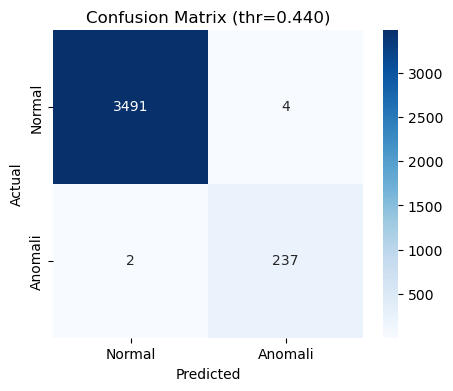

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# En iyi threshold'tan tahmin
best_thr = 0.440
y_pred_best = (proba_test >= best_thr).astype(int)

cm = confusion_matrix(y_test, y_pred_best)
labels = ["Normal", "Anomali"]

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (thr={best_thr:.3f})")
plt.show()

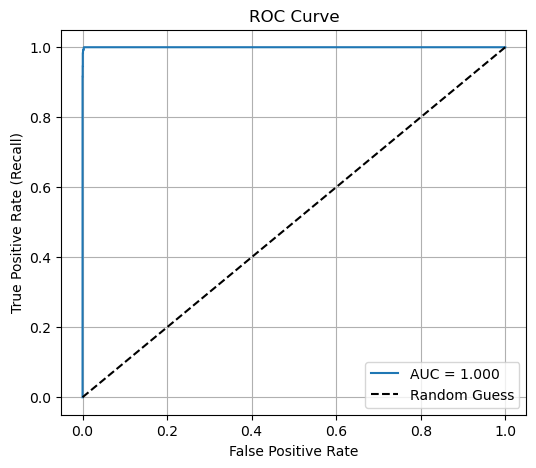

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, proba_test)
auc = roc_auc_score(y_test, proba_test)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

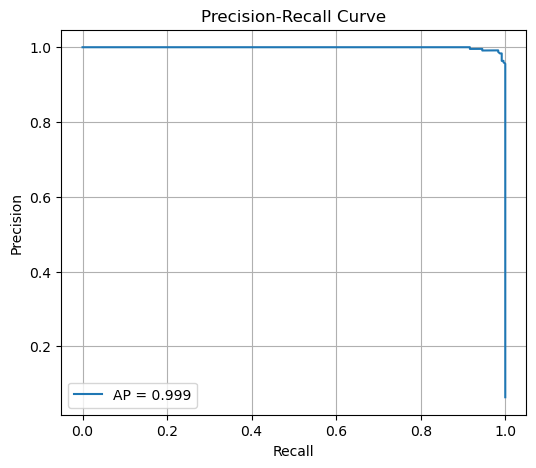

In [38]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(y_test, proba_test)
ap = average_precision_score(y_test, proba_test)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()